In [404]:
import itertools
import re

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from tabDatabase import *
import pandas as pd
from sqlalchemy import select, update, bindparam
from shortname import short_school_name, chapter_code

total_entries = 1967409
total_entries_with_students = 615613
caselist_total = 338521
metadata.create_all(tabEngine)
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 20)
tqdm.pandas()

In [403]:
# %load_ext autoreload
%autoreload

# Create Teams

In [2]:
def get_team_values(row_group):
    students = [record[2] for record in row_group]
    num_debaters = len(students)
    students += [None] * (5 - len(students)) # when negative ignores
    return { f"debater{i + 1}": students[i] for i in range(5) } | {
        "other_debaters":  ','.join(map(str, students[5:])) if len(students) > 5 else None,
        "num_debaters": num_debaters
    }

In [45]:
def chunked_iterable(iterable, size):
    it = iter(iterable)
    while True:
        s = list(itertools.islice(it, size))
        if not s: break
        yield s

In [ ]:
from sqlalchemy.dialects.sqlite import insert

with tabEngine.connect() as conn:
    query = entry_student_table.select().order_by('entry', 'student')
    entry_groups = conn.execute(query)

data = tqdm((
    (entry, get_team_values(group))
    for entry, group in itertools.groupby(entry_groups, lambda x: x[1])
), total=total_entries_with_students)

chunk_size = 10000
for chunk in chunked_iterable(data, chunk_size):
    with tabEngine.begin() as conn:
        values = [record[1] for record in chunk]
        stmt = insert(team_table)
        stmt = stmt.on_conflict_do_update(index_elements=team_unique, set_=team_table.c) # Do dummy update so id is returned
        stmt = stmt.returning(team_table.c.id)

        teams = (value[0] for value in conn.execute(stmt, values))
        entries = (record[0] for record in chunk)

        for entry, team_id in zip(entries, teams):
            conn.execute(entry_table.update().where(entry_table.c.id == entry).values({'team': team_id}))


In [40]:
# with engine.begin() as con:
#     con.execute(team_table.delete())
#     con.execute(entry_table.update().values({'team': None}))

# Add short codes and schools

In [298]:
def getSections(entry_name: str) -> list[str]:
    if ' - ' in entry_name and ' and ' in entry_name: # Some were formatted like this before 2015-2016 season
        entry_name = entry_name.split(' - ')[1]
    sections = re.split(r', | & | and ', entry_name)
    return [s.strip() for s in sections if s.strip()] # Filter out empty and trim

In [299]:
def getShortName(entry_name: str) -> str | None:
    """Convert entry name to short name. Sorts short name for teams with 2 people"""
    if entry_name is None: return None
    if re.match(r'Entry \d+', entry_name): return None

    sections = getSections(entry_name)
    if len(sections) == 1: sections = sections[0].split(' ') # For single person teams split by first and last
    else: sections = sorted(sections) # Normalize team names to be sorted

    if len(sections) != 2: return None

    short_name = sections[0][0] + sections[1][0]
    return short_name if short_name.isupper() else None

In [300]:
def getSchool(entry_code: str, entry_name: str) -> str | int | float:
    """Get school from entry code. Uses entry_name to identify names in code"""
    if entry_code is None or entry_name is None: return 1
    entry_code = entry_code.strip()
    entry_name = entry_name.strip()
    name_sections = [re.escape(section) for section in getSections(entry_name)]

    # numbers
    if ' ' not in entry_code: return 2
    # names (single person), last_names (single person)
    if entry_code in entry_name: return 3
    if len(name_sections) == 1:
        split = entry_code.split(', ')
        # names_lastfirst (single person)
        if len(split) == 2 and split[0] in entry_name and split[1] in entry_name: return 4.1
    else:
        # last_names (multiple person)
        if entry_code == ' & '.join(name_sections): return 5
        # names (multiple person) *Also filters school_names (multiple person)
        if re.fullmatch(' & '.join([fr'(.+ {section})' for section in name_sections]), entry_code): return 6
        # names_lastfirst (multiple person)
        if re.fullmatch(' & '.join([fr'({section}, .+)' for section in name_sections]), entry_code): return 4.2

    code_patterns = [
        r'\d+', # school_number, schoolname_code
        r'[A-Z]{2}', # initials, full_initials
        re.escape(entry_name), # school_names  (single person)
        ' & '.join(name_sections) # code_name, school_last_names (multiple person)
    ]
    # school_last_names (single person), school_first_name (single person)
    if len(name_sections) == 1:
        names = entry_name.split(' ')
        if len(names) == 2: code_patterns += [re.escape(n) for n in names]

    # print(fr'^(.*?) ({"|".join(code_patterns)})$')
    match = re.fullmatch(fr'(.*?) ({"|".join(code_patterns)})', entry_code)
    # Should filter school_name_only, school_first_names (multiple person)
    # If register I cry
    if match is None: return 7

    school = match.group(1).strip()
    if re.fullmatch('\d+|[A-Z]{1,2}|[A-Z]{1,2} \d+', school): return 8 # Filter incremental school codes
    if not school: return 9
    return school

In [321]:
from collections import Counter
import numbers

data = []
errors = Counter()
with tabEngine.begin() as conn:
    q = select(entry_table.c.id, entry_table.c.name, entry_table.c.code, entry_table.c.team)
    for entry_id, name, code, team in tqdm(conn.execute(q), total=total_entries):
        school = getSchool(code, name)
        if isinstance(school, numbers.Number):
            errors[school] += 1
            school = None
        data.append({
            'id': entry_id,
            'name': name,
            'short_name': getShortName(name),
            'code': code,
            'school_name': school,
            'team': team
        })
entries = pd.DataFrame(data)
data = None


  0%|          | 0/1967409 [00:00<?, ?it/s]

In [381]:
entries.short_name.notna().mean(), entries.school_name.notna().mean()

(0.922141252784754, 0.4026503894208068)

In [388]:
entries['school_code'] = entries.school_name.progress_apply(lambda s: chapter_code(short_school_name(s)))

  0%|          | 0/1967409 [00:00<?, ?it/s]

In [ ]:
# entries['short_school_name'] = entries.school_name.progress_apply(short_school_name)
# entries['chapter_code'] = entries.school_name.progress_apply(chapter_code)
# entries['short_school_name_code'] = entries.school_name.progress_apply(lambda s: chapter_code(short_school_name(s)))

In [380]:
entries.to_feather('./data/entries.feather')

In [406]:
with tabEngine.begin() as conn:
    insert_q = update(entry_table)\
        .where(entry_table.c.id == bindparam('entry_id'))\
        .values({'short_name': bindparam('short_name'), 'school_name': bindparam('school_name'), 'school_code': bindparam('school_code')})
    conn.execute(insert_q, entries.rename(columns={'id': 'entry_id'}).to_dict('records')[1:])

# Analyze

In [354]:
def plot_gte(nums, label: str):
    counts = pd.Series(nums).value_counts()
    sums = np.cumsum(counts.sort_index()[::-1])[::-1]
    plt.plot(sums, label=label)
    plt.scatter(sums.index, sums)
    return sums

In [249]:
entries.sample(100)

,id,name,short_name,code,school_name,team
114484,826305,Drake Olson,DO,81 Drake Olson,None,NaN
782342,2532540,Leipzig & Kiefer,KL,Glenbrook South KL,Glenbrook South,114959.0
574915,2054801,Tansey & Speece,ST,St. Ambrose TS,St. Ambrose,94336.0
1507785,3927593,Chen & Sreekanthan,CS,Joaquin Miller CS,Joaquin Miller,188442.0
386684,1581374,Biraj Choudhury,BC,1069,None,NaN
...,...,...,...,...,...,...
145621,934643,Rachel Kho,RK,RV Rachel Kho,None,NaN
417594,1662708,Isaac Ramnani,IR,KJ Isaac Ramnani,None,NaN
54137,598103,Eagen & Simmons,ES,Liberty ES,Liberty,10106.0
1633369,4174272,Tian & Tang,TT,Potoma TT,Potoma,112126.0


In [96]:
with tabEngine.begin() as conn:
    old_entries = pd.read_sql(text("""
        select id, name, short_code, code, school_name, team from entry
    """), con=conn)

In [356]:
def plotSchoolCounts(df: pd.DataFrame, col='school_name'):
    school_counts = df.groupby('team')[col].nunique()
    print(school_counts[school_counts > 0].mean())
    print(plot_gte(school_counts, col))

school_name
1.1205900443741488
0    237523
1    182088
2     18628
3      2502
4       598
5       170
6        48
7        11
8         1
Name: school_name, dtype: int64
short_school_name
1.114488598919204
0    237523
1    182088
2     17860
3      2283
4       523
5       139
6        36
7         6
Name: short_school_name, dtype: int64
chapter_code
1.051046746628004
0    237523
1    182088
2      8039
3      1042
4       168
5        36
6         9
7         1
Name: chapter_code, dtype: int64
short_school_name_code
1.0491136153947542
0    237523
1    182088
2      7709
3      1018
4       177
5        33
6         6
Name: short_school_name_code, dtype: int64


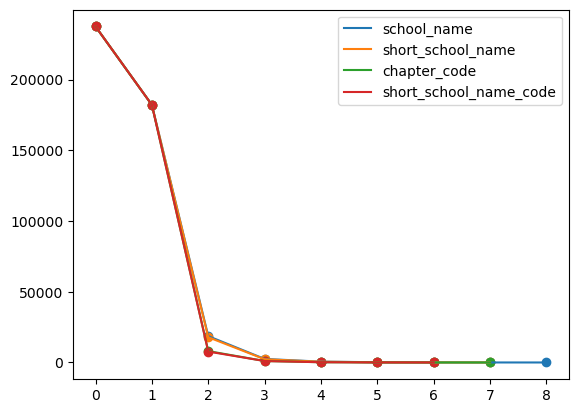

In [360]:
for c in ['school_name', 'short_school_name', 'chapter_code', 'short_school_name_code']:
    print(c)
    plotSchoolCounts(entries, c)
plt.legend()

In [362]:
team_school_counts = entries.groupby('team').chapter_code.nunique()

In [369]:
multi = team_school_counts[team_school_counts >= 2].index

In [376]:
multi_entries = entries[entries.team.isin(multi)]
multi_entries = multi_entries[multi_entries.school_name.notna()].sort_values('team')
multi_entries[['code', 'school_name', 'chapter_code', 'team']].drop_duplicates(subset=['team', 'school_name'])

,code,school_name,chapter_code,team
34794,Hunter College DL,Hunter College,HunCol,164.0
32034,Hunter DL,Hunter,Hunter,164.0
31001,Hunter College RH,Hunter College,HunCol,170.0
32032,Hunter RH,Hunter,Hunter,170.0
31003,Hunter College BL,Hunter College,HunCol,189.0
...,...,...,...,...
1959986,NHCS 300,NHCS,NHCS,232941.0
1915647,Barack Obama CT,Barack Obama,BarOba,234377.0
1956963,Barack Obama Male Leadership Academy (HS) CT,Barack Obama Male Leadership Academy (HS),BOMLAH,234377.0
1945298,CdA 217,CdA,CdA,236073.0


In [311]:
school_team_counts = entries.groupby('school_name').team.nunique().sort_values(ascending=False)
school_team_counts

school_name
Potomac                                    1157
Potoma                                      863
Harker                                      746
Lexington                                   728
Bronx Science                               700
                                           ... 
Mahtomedi Debate Team                         0
Chole                                         0
Chongqing Experimental Foreign Language       0
Rex Hot Chili Peppers                         0
Lab 3                                         0
Name: team, Length: 21993, dtype: int64

In [315]:
school_team_counts.loc[school_team_counts.index.str.contains(" ")].sum()

92507

In [247]:
entries[entries.team == 589]

,id,name,short_name,code,school_name,team
15589,345396,Kansas State - Klucas and Mays,KM,KSU KM,KSU,589.0
16322,347643,Klucas & Mays,KM,KState KM,KState,589.0
17197,355830,Mays & Klucas,KM,KState KM,KState,589.0
21451,398238,Kansas State - Klucas and Mays,KM,KState KM,KState,589.0
21452,398239,Kansas State - Klucas and Mays,KM,KSU KM,KSU,589.0
22464,410323,Kansas State - Klucas and Mays,KM,KState KM,KState,589.0
22478,410677,Kansas State - Klucas and Mays,KM,KState KM,KState,589.0
23164,424036,Klucas & Mays,KM,KanSta K,None,589.0
25171,436230,Kansas State - Klucas and Mays,KM,KState KM,KState,589.0
25205,436534,Klucas & Mays,KM,KanSta KM,KanSta,589.0


In [169]:
initial_code = entries[entries.code.str.match(r'.* [A-Z]{2}$').fillna(False)]
initial_code = initial_code[initial_code.short_name.notna()]

In [174]:
initial_code

,id,name,short_name,code,school_name,team
14147,340655,Minnesota CE,MC,Minn CE,Minn,NaN
14148,340656,Minnesota FS,MF,Minn FS,Minn,NaN
14149,340657,Georgetown AM,GA,GTown AM,GTown,NaN
14150,340658,Georgetown DE,GD,GTown DE,GTown,NaN
14151,340659,Georgetown CV,GC,GTown CV,GTown,NaN
...,...,...,...,...,...,...
1967300,4823934,Josie Cochran,JC,29 JC,None,237415.0
1967301,4824723,Willson & Houston,HW,Wyoming/Oklahoma WH,Wyoming/Oklahoma,237416.0
1967397,4828453,Katherine White,KW,27 KW,None,237512.0
1967400,4828479,Ian Metzger,IM,23 IM,None,237515.0


In [175]:
matches = initial_code.apply(lambda entry: entry['code'].endswith(entry['short_name']), axis=1)

In [97]:
old_entries.to_feather('./data/old_entries.feather')